## Importing Libraries and Setting Up the Environment for VGG16 Training

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing the libraries
import os, sys

# Add the module path to the sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Importing the libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import random_split

In [2]:
# Import local helper files
from utils.evaluation import set_all_seeds, compute_confusion_matrix
from utils.train import train_model
from utils.plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from utils.dataset import UnNormalize

## Setting Up Training Parameters for VGG16

In this section, we define several settings that will be used for training the VGG16 model:

- `RANDOM_SEED`: This is the seed for the random number generator. We set it to ensure that our experiments can be reproduced.
- `BATCH_SIZE`: This is the number of training examples utilized in one iteration. We set it to 256.
- `NUM_EPOCHS`: The number of times the entire training dataset is shown to the network during training. Set to 8 in this case.
- `DEVICE`: This is the device where the tensor computations will be performed. We set it to use the first CUDA device if available, otherwise it falls back to CPU.

In [3]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 8
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
set_all_seeds(RANDOM_SEED)

## Preprocessing and Loading the Furniture Dataset for VGG16 Model

In this section, we perform several preprocessing steps on the furniture dataset and load it into memory:

1. **Define Transformations**: We define transformations for the training and testing datasets. For the training dataset, we resize the images to 120x120, perform a random crop to 110x110, convert the images to PyTorch tensors, and normalize them. For the testing dataset, we perform the same steps, but replace the random crop with a center crop.

2. **Load the Dataset**: We load the dataset from the specified path and apply the training transformations.

3. **Split the Dataset**: We split the dataset into training, validation, and testing sets according to the specified proportions.

4. **Apply Test Transformations**: We apply the testing transformations to the validation and testing datasets.

5. **Create Data Loaders**: We create data loaders for the training, validation, and testing datasets. These will allow us to efficiently iterate over the datasets during training.

6. **Check the Dataset**: We print out the dimensions of an image batch and label batch from the training dataset, as well as the class labels of 10 examples, to ensure everything is working correctly.

In [5]:
##########################
### FURNITURE_DATA
##########################

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),
    torchvision.transforms.RandomCrop((110, 110)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),        
    torchvision.transforms.CenterCrop((110, 110)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

path = "../../Data/Furniture_Data/"
train_val_test_split = [0.8, 0.15, 0.05]


# Load the dataset
dataset = datasets.ImageFolder(root=path, transform=train_transforms)

# Determine sizes for each split
total_size = len(dataset)
train_size = int(train_val_test_split[0] * total_size)
valid_size = int(train_val_test_split[1] * total_size)
test_size = total_size - train_size - valid_size

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# Apply test transform to validation and test datasets
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

## Implementing VGG16 Architecture in PyTorch

This code block implements the VGG16 (Visual Geometry Group) architecture in PyTorch. VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”.

The VGG16 model consists of 16 layers that include convolutional layers, max pooling layers, and fully connected layers. It also includes ReLU activation functions and dropout layers for regularization.

1. **Convolutional Blocks**: The model is divided into five blocks. Each block consists of several convolutional layers followed by a max pooling layer. The number of convolutional layers and the number of output channels increase with each block.

2. **Fully Connected Layers**: After the convolutional blocks, the model has three fully connected layers. The first two have 4096 nodes each and use the ReLU activation function. The last fully connected layer has a number of nodes equal to the number of classes and is used for the final classification.

3. **Initialization**: The weights of the convolutional and fully connected layers are initialized using the He initialization method (also known as Kaiming initialization). This method is designed to keep the scale of the gradients roughly the same in all layers.

4. **Forward Method**: The forward method defines the forward pass of the network. It takes an input tensor and passes it through the blocks, the average pooling layer, and the fully connected layers. The output is a tensor of logits.

In [6]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_3 = torch.nn.Sequential(        
                torch.nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
          
        self.block_4 = torch.nn.Sequential(   
                torch.nn.Conv2d(in_channels=256,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_5 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),    
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))             
        )
            
        height, width = 3, 3 ## Varies based on image size
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512*height*width, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
        self.avgpool = torch.nn.AdaptiveAvgPool2d((height, width))
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten
        
        logits = self.classifier(x)

        return logits                                

## Training and Evaluating the VGG16 Model

In this section, we train and evaluate the VGG16 model on our dataset:

1. **Model Setup**: We initialize a VGG16 model with 6 classes and move it to the appropriate device (CPU or GPU).

2. **Optimizer and Scheduler Setup**: We set up the Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.01 and momentum of 0.9. We also set up a learning rate scheduler that reduces the learning rate when the validation accuracy plateaus.

3. **Model Training**: We train the model using the `train_model` function. This function trains the model for a specified number of epochs and returns lists of the minibatch loss and training and validation accuracies at each epoch.

4. **Loss Plotting**: We plot the training loss over time using the `plot_training_loss` function. This function creates a plot of the training loss at each minibatch over the course of the entire training process.

5. **Accuracy Plotting**: We plot the training and validation accuracies over time using the `plot_accuracy` function. This function creates a plot of the training and validation accuracies at each epoch over the course of the entire training process.

c:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 001/008 | Batch 0000/0247 | Loss: 3.7199
Epoch: 001/008 | Batch 0100/0247 | Loss: 0.8970
Epoch: 001/008 | Batch 0200/0247 | Loss: 0.5894
Epoch: 001/008 | Train: 78.66% | Validation: 78.93%
Time elapsed: 74.14 min
Epoch: 002/008 | Batch 0000/0247 | Loss: 0.5904
Epoch: 002/008 | Batch 0100/0247 | Loss: 0.4252
Epoch: 002/008 | Batch 0200/0247 | Loss: 0.3081
Epoch: 002/008 | Train: 88.38% | Validation: 88.15%
Time elapsed: 141.89 min
Epoch: 003/008 | Batch 0000/0247 | Loss: 0.4343
Epoch: 003/008 | Batch 0100/0247 | Loss: 0.3365
Epoch: 003/008 | Batch 0200/0247 | Loss: 0.3029
Epoch: 003/008 | Train: 90.93% | Validation: 90.36%
Time elapsed: 216.03 min
Epoch: 004/008 | Batch 0000/0247 | Loss: 0.3080
Epoch: 004/008 | Batch 0100/0247 | Loss: 0.1918
Epoch: 004/008 | Batch 0200/0247 | Loss: 0.1947
Epoch: 004/008 | Train: 94.24% | Validation: 93.24%
Time elapsed: 291.99 min
Epoch: 005/008 | Batch 0000/0247 | Loss: 0.1541
Epoch: 005/008 | Batch 0100/0247 | Loss: 0.1720
Epoch: 005/008 | Batc

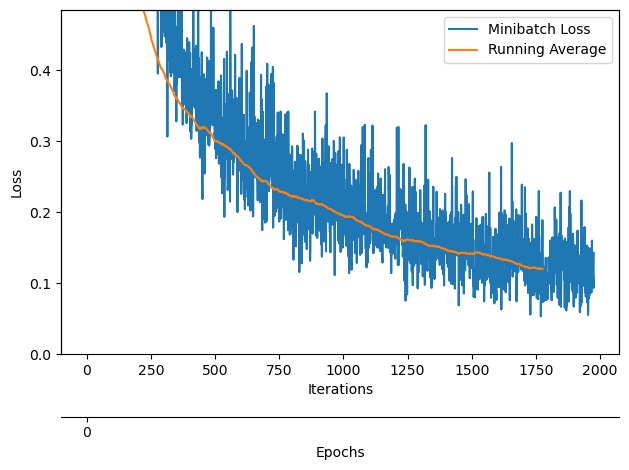

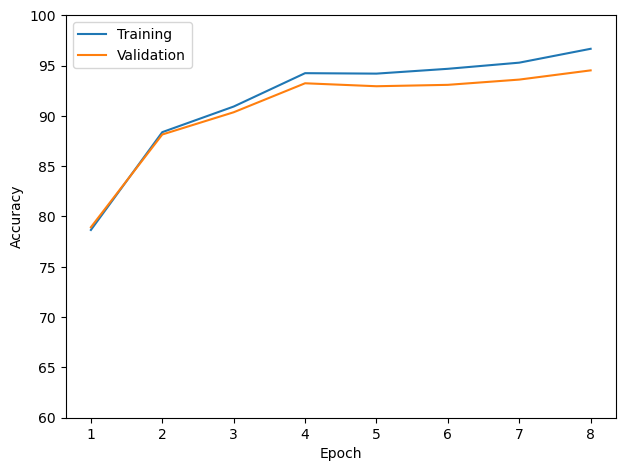

In [7]:
model = VGG16(num_classes=6)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

## Saving the trained model

In [8]:
torch.save(model.state_dict(), 'vgg16_state_dict.pth')
torch.save(model, 'vgg16.pth')